In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [53]:
#Defining a array of ones symbolizing the atoms of Ti
TiPb=np.ones(1000)
#Array to count number of Ti atom every timestep
cnt=[]
#Definining tau in seconds
tau=3.052*60
#Cicling over time and calculating the probability to decay using a accept-reject method over
#each atom and each time step
for t in np.arange(1000):
    for i,j in enumerate(TiPb):
        if np.random.rand()<1-2**(-1/tau) and j!=0:
            TiPb[i]=0
    cnt.append(len(TiPb[TiPb==1]))
    

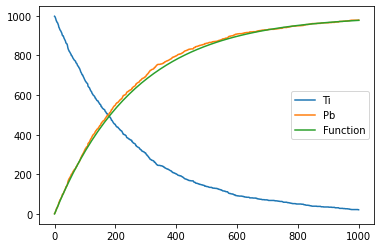

In [54]:
#Plotting the two curves and comparing the function used to calculate probability
plt.plot(cnt,label="Ti")
plt.plot(1000-np.asarray(cnt),label="Pb")
x=np.linspace(0,1000)
plt.plot(x,1000*(1-2**(-x/tau)), label="Function")
plt.legend()

Calculating the inverse cumulative function we obtain $t=-\frac{\log(1-x)}{\log(2)}$ where x is a number taken randomically between 0 and 1. Using this we obtain the decay times.

In [44]:
#Using the function obtained inverting cumulative function
times=np.random.rand(1000)
times=-np.log(1-times)/np.log(2)

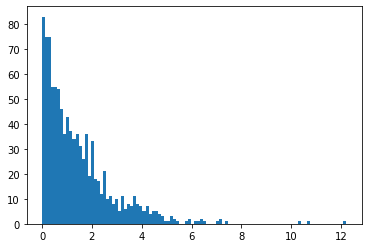

In [46]:
#Plotting an histogram for the distribution of decay times and getting the count for every bin
cnt=plt.hist(times,100)
cnt=cnt[0]

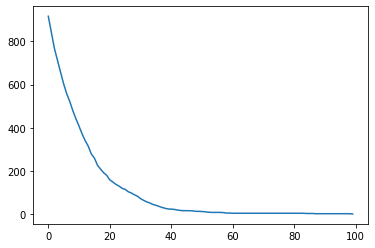

In [47]:
#Using the cumulative count over the decay times to get the number of surving Ti atoms
plt.plot(1000-cnt.cumsum())

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [49]:
#Inserting the constant
a0= 5.291777721092e4
n = 1000000
#Getting the x and y distribution using Box-Muller method
z = np.random.random(n)
theta = 2*np.pi*np.random.random(n)
r = np.sqrt(-2*np.log(1-z)*(a0/100)**2)
x = r*np.cos(theta)
y = r*np.sin(theta)
#Getting impact parameter value
b=np.sqrt(x**2+y**2)

We can get a limit value for rebounded particles as 
$$
\tan{\frac{\pi}{4}} < \frac{Z e^2} {2\pi \epsilon_0 E b} \Rightarrow b < \frac{Z e^2} {2\pi \epsilon_0 E}
$$

In [56]:
#Getting percentual of the number of rebounded particle using the previous inequality
print(len(b[b<(79*2*197)/(137*7.7)])/len(b),"%")

0.001567 %


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [78]:
#Defining the function
def f(x):
    return (np.sin(1/(x*(2-x))))**2
I_e=integrate.quad(f,0,2)[0]
print("Estimated result: ",I_e)

Estimated result:  1.4516877509810684


<ipython-input-78-bd610e0892b4>:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I_e=integrate.quad(f,0,2)[0]


In [82]:
# Using Monte Carlo integration with hit or miss method
N=1000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
print("Integral value: ",I)
print("Error w.r.t estimate: ", abs(I-I_e))

Integral value:  1.444
Error w.r.t estimate:  0.007687750981068442


In [83]:
#Integrating using mean value method
sumv=f(np.random.rand(N))
sumv=sumv.sum()
I=(2/N)*(sumv)
print("Integral value: ",I)
print("Error w.r.t estimate: ", abs(I-I_e))

Integral value:  1.456496717651355
Error w.r.t estimate:  0.00480896667028663


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [128]:
#Defining the main function
def f(x):
    r=np.linalg.norm(x)
    if r <= 1:
        return 1
    else:
        return 0
#Defining the volume function
def NDvolume(iters,dim):
    count=0
    for i in range(iters):
        x=np.random.random(dim)
        count+=f(x) #Equivalent to ask to a random variable to be under the function 
    return (2**dim)*count/iters


In [130]:
print("Circle area: ",NDvolume(10000000,2))
print("10D volume: ",NDvolume(10000000,10))

Circle area:  3.1415364
10D volume:  2.544128


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [6]:
#Defining x and w functions
def f(x):
    return x**(-0.5)/(np.exp(x)+1)
def w(x):
    return 1/(np.sqrt(x))

In [7]:
#Defining and creating the random variables
N=1000000
#Getting a serie of numbers distributed as w (cumulative function is sqrt(y) and the inverse is (x^2))
x=(np.random.random(N)**2)

print("The integral value is: ", (2/N)*(f(x)/w(x)).sum())

The integral value is:  0.8389372188208872
